### Geok Compressed data XGboost training and testing

In [9]:
import os
import json
from datetime import datetime, timedelta
from pathlib import Path
from typing import Tuple, Optional, Union, List, Dict
from dataclasses import dataclass, field
import multiprocessing
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
from scipy.stats import skew, kurtosis, entropy, randint, uniform, loguniform
from scipy.fft import fft
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.calibration import calibration_curve
import xgboost as xgb
from xgboost import plot_importance
import joblib
from joblib import Parallel, delayed
import pyarrow as pa
from tqdm import tqdm
import mlflow
from mlflow.models.signature import infer_signature

import matplotlib.pyplot as plt


from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,
    precision_recall_curve, average_precision_score, confusion_matrix, classification_report
)



import pyarrow.parquet as pq



In [10]:
# Set MlFlow tracking URI
mlflow.set_tracking_uri("http://localhost:8080") # Check your MLflow server URI

In [11]:
class DDMFeatureExtractor:
    def __init__(self):
        pass
    @staticmethod
    def gini(array):
            """Gini coefficient calculation"""
            array = np.sort(array)
            index = np.arange(1, array.shape[0] + 1)
            return (np.sum((2 * index - array.shape[0] - 1) * array)) / (array.shape[0] * np.sum(array))  
      
    def extract_ddm_features(self, fit_data: np.ndarray) -> pd.DataFrame:
        """
        Extract features from DDM data.
        """
        features = []

        for row in tqdm(fit_data, desc="Extracting DDM features"):
            f = {}
            x = np.array(row, dtype=np.float64) + 1e-10  # evita log(0)

            # 1. General statistics
            f['mean'] = np.mean(x)
            f['std'] = np.std(x)
            f['min'] = np.min(x)
            f['max'] = np.max(x)
            f['median'] = np.median(x)
            f['range'] = np.max(x) - np.min(x)
            f['skew'] = skew(x)
            f['kurtosis'] = kurtosis(x)
            f['entropy'] = entropy(x)
            f['gini'] = self.gini(x)

            # 2. Positional 
            f['peak_index'] = np.argmax(x)
            f['peak_value'] = np.max(x)
            f['center_of_mass'] = np.sum(np.arange(len(x)) * x) / np.sum(x)
            f['inertia'] = np.sum(((np.arange(len(x)) - f['center_of_mass'])**2) * x)

            # 3. Segmentations in thirds
            thirds = np.array_split(x, 3)
            for i, part in enumerate(thirds):
                f[f'sum_third_{i+1}'] = np.sum(part)
                f[f'mean_third_{i+1}'] = np.mean(part)
                f[f'max_third_{i+1}'] = np.max(part)

            # 3.1 Segmentations in windows of 5
            windows = np.array_split(x, 5)
            for i, w in enumerate(windows):
                f[f'mean_w{i+1}'] = np.mean(w)
                f[f'std_w{i+1}'] = np.std(w)
                f[f'max_w{i+1}'] = np.max(w)

            # 4. Derivative statistics and differences
            dx = np.diff(x)
            f['mean_diff'] = np.mean(dx)
            f['std_diff'] = np.std(dx)
            f['max_diff'] = np.max(dx)
            f['min_diff'] = np.min(dx)
            f['n_positive_diff'] = np.sum(dx > 0)
            f['n_negative_diff'] = np.sum(dx < 0)
            f['n_zero_diff'] = np.sum(dx == 0)

            # 5. Autocorrelations (lag 1-3)
            for lag in range(1, 4):
                ac = np.corrcoef(x[:-lag], x[lag:])[0, 1] if len(x) > lag else np.nan
                f[f'autocorr_lag{lag}'] = ac

            # 6. FFT 
            spectrum = np.abs(fft(x)) # type: ignore
            half_spectrum = spectrum[:len(spectrum)//2]  
            f['fft_peak_freq'] = np.argmax(half_spectrum)
            f['fft_max'] = np.max(half_spectrum)
            f['fft_median'] = np.median(half_spectrum)
            f['fft_mean'] = np.mean(half_spectrum)


            features.append(f)
        return features # type: ignore

In [12]:
class XGBoostPipeline:
    def __init__(self, features_df, labels_df, test_size=0.2, random_state=42, 
                 experiment_name="xgboost_binary_classification", model_save_dir="./models", save_voter=True):
        
        self.features_df = features_df
        self.labels_df = labels_df.values.ravel() if isinstance(labels_df, pd.DataFrame) else labels_df
        self.test_size = test_size
        self.random_state = random_state
        self.model = None
        self.best_params = None
        self.cv_results = None
        self.scaler = None
        self.save_voter = save_voter

        # MLflow setup
        self.experiment_name = experiment_name
        self.model_save_dir = model_save_dir
        self.run_id = None

        # Create output directory if it doesn't exist
        if not os.path.exists(model_save_dir):
            print(f"Creating model save directory: {model_save_dir}")
            os.makedirs(model_save_dir, exist_ok=True)

        # Setup MLflow experiment
        self._setup_mlflow_experiment()

    def _setup_mlflow_experiment(self):
        try:
            experiment = mlflow.get_experiment_by_name(self.experiment_name)
            if experiment is None:
                mlflow.create_experiment(self.experiment_name)

            mlflow.set_experiment(self.experiment_name)
            print(f"MLflow experiment '{self.experiment_name}' correctly set up.")

        except Exception as e:
            print(f"Error in mlflow configuration: {e}")

    def _log_to_mlflow(self, key, value):
        try:
            if isinstance(value, (int, float)):
                mlflow.log_metric(key, value)
            else:
                mlflow.log_param(key, value)
        except Exception as e:
            print(f"Error logging MLflow {key}: {e}")

    def prepare_data(self):
        """Split data into train and test sets"""
        print("=== Data preparation ===")

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.features_df, self.labels_df, 
            test_size=self.test_size, 
            random_state=self.random_state,
            stratify=self.labels_df
        )

        # Features scaling
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        try:
            mlflow.log_param("dataset_total_samples", len(self.features_df))
            mlflow.log_param("train_samples", self.X_train.shape[0])
            mlflow.log_param("test_samples", self.X_test.shape[0])
            mlflow.log_param("n_features", self.X_train.shape[1])
            mlflow.log_param("test_size", self.test_size)
            mlflow.log_param("random_state", self.random_state)

            class_distribution = pd.Series(self.y_train).value_counts(normalize=True)
            for class_label, proportion in class_distribution.items():
                mlflow.log_metric(f"class_{class_label}_proportion", proportion)

        except Exception as e:
            print(f"Error mlflow: {e}")

        print("Dataset dimensions:")
        print(f"Train set: {self.X_train.shape[0]} campioni")
        print(f"Test set: {self.X_test.shape[0]} campioni")
        print(f"Features: {self.X_train.shape[1]}")
        print("\nClass distribution:")
        print(pd.Series(self.y_train).value_counts(normalize=True))

    def hyperparameter_tuning(self, cv_folds=5, verbose=True, n_iter=250):
        print("\n=== HYPERPARAMETER TUNING ===")

        self.param_distributions = {
            'n_estimators': [500, 1000, 1500],
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.001, 0.03, 0.005],
            'subsample': uniform(0.4, 0.6),     
            'colsample_bytree': uniform(0.4, 0.6), 
            #'colsample_bylevel': uniform(0.4, 0.6),
            #'colsample_bynode': uniform(0.4, 0.6), 
            'gamma': loguniform(1e-8, 1),
            'reg_alpha': loguniform(1e-8, 10),   
            'reg_lambda': loguniform(1e-8, 10),
            'min_child_weight': randint(1, 10),
            #'scale_pos_weight': uniform(0.5, 5.0),
            #'booster': ['gbtree', 'dart'],
        }

        try:
            mlflow.log_param("cv_folds", cv_folds)
            mlflow.log_param("search_iterations", n_iter)
            mlflow.log_param("search_scoring", "roc_auc")

            # Log hyperparameter search space
            for param, distribution in self.param_distributions.items():
                if hasattr(distribution, 'args'):
                    mlflow.log_param(f"search_space_{param}", str(distribution.args))
                else:
                    mlflow.log_param(f"search_space_{param}", str(distribution))

        except Exception as e:
            print(f"{e}")

        n_cores = multiprocessing.cpu_count()
        self.n_jobs = np.floor(0.75 * n_cores).astype(int)
        print(f"Using {self.n_jobs} cores for hyperparameter tuning (75% of {n_cores} total cores).")

        # Base model
        base_model = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            tree_method='hist',
            use_label_encoder=False,
            random_state=self.random_state,
            n_jobs=self.n_jobs
        )

        # Stratified K-Fold
        stratified_kfold = StratifiedKFold(
            n_splits=cv_folds, 
            shuffle=True, 
            random_state=self.random_state
        )

        # RandomizedSearchCV
        self.grid_search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=self.param_distributions,
            n_iter=n_iter,
            cv=stratified_kfold,
            scoring='roc_auc',
            n_jobs=self.n_jobs,
            verbose=2,
            random_state=self.random_state,
            return_train_score=True
        )

        
        print("Searching for hyperparameters!")
        self.grid_search.fit(self.X_train_scaled, self.y_train)

        self.best_params = self.grid_search.best_params_
        self.cv_results = pd.DataFrame(self.grid_search.cv_results_)

        try:
            mlflow.log_metric("best_cv_score", self.grid_search.best_score_)

            for param, value in self.best_params.items():
                mlflow.log_param(f"best_{param}", value)

            cv_results_path = os.path.join(self.model_save_dir, "cv_results.csv")
            self.cv_results.to_csv(cv_results_path, index=False)
            mlflow.log_artifact(cv_results_path, "hyperparameter_search")

        except Exception as e:
            print(f"Error in mlflow logging: {e}")

        print("\nBest hyperparameters found:")
        for param, value in self.best_params.items():
            print(f"  {param}: {value}")
        print(f"\nBest  ROC-AUC (CV): {self.grid_search.best_score_:.4f}")

        self._plot_hyperparameter_results()

    def train_final_model(self):
        """Finalize the model training with the best hyperparameters found"""
        print("\n=== Finalizing model ===")

        self.model = xgb.XGBClassifier(
            **self.best_params,
            objective='binary:logistic',
            eval_metric='logloss',
            random_state=self.random_state,
            n_jobs=self.n_jobs
        )

        
        # Split a validation set from the training data for evaluation
        print("Splitting training data for final model training...")
        self.X_train_final, self.X_eval, self.y_train_final, self.y_eval = train_test_split(
            self.X_train_scaled, self.y_train,
            test_size=0.1,  # 10% of training data for evaluation
            random_state=self.random_state,
            stratify=self.y_train
        )

        eval_set = [(self.X_train_final, self.y_train_final), (self.X_eval, self.y_eval)]

        self.model.fit(
            self.X_train_final, self.y_train_final,
            eval_set=eval_set,
            verbose=False
        )

        self.y_pred = self.model.predict(self.X_test_scaled)
        self.y_pred_proba = self.model.predict_proba(self.X_test_scaled)[:, 1]

        metrics = {
            'accuracy': accuracy_score(self.y_test, self.y_pred),
            'precision': precision_score(self.y_test, self.y_pred),
            'recall': recall_score(self.y_test, self.y_pred),
            'f1_score': f1_score(self.y_test, self.y_pred),
            'roc_auc': auc(*roc_curve(self.y_test, self.y_pred_proba)[:2]),
            'average_precision': average_precision_score(self.y_test, self.y_pred_proba)
        }

        # Log metrics MLflow
        try:
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"test_{metric_name}", metric_value)

            
            mlflow.log_metric("n_estimators_used", self.model.n_estimators)

        except Exception as e:
            print(f"Error logging metrics: {e}")

        print("\nMetrics on test set:")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name.replace('_', ' ').title()}: {metric_value:.4f}")

    
    def save_model_and_scaler(self, model_name=None):
        print("\n=== Saving finalized model and scaler ===")

        if model_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            model_name = f"xgboost_model_{timestamp}"

        model_path = os.path.join(self.model_save_dir, f"{model_name}.joblib")
        scaler_path = os.path.join(self.model_save_dir, f"{model_name}_scaler.joblib")
        metadata_path = os.path.join(self.model_save_dir, f"{model_name}_metadata.json")

        try:
            # Save model and scaler
            joblib.dump(self.model, model_path)
            print(f"Model saved in: {model_path}")
            joblib.dump(self.scaler, scaler_path)
            print(f"Scaler saved in: {scaler_path}")

            metadata = {
                'model_name': model_name,
                'timestamp': datetime.now().isoformat(),
                'best_params': self.best_params,
                'cv_score': float(self.grid_search.best_score_),
                'test_metrics': {
                    'accuracy': float(accuracy_score(self.y_test, self.y_pred)),
                    'precision': float(precision_score(self.y_test, self.y_pred)),
                    'recall': float(recall_score(self.y_test, self.y_pred)),
                    'f1_score': float(f1_score(self.y_test, self.y_pred)),
                    'roc_auc': float(auc(*roc_curve(self.y_test, self.y_pred_proba)[:2]))
                },
                'feature_names': list(self.features_df.columns),
                'n_features': len(self.features_df.columns),
                'train_samples': len(self.y_train),
                'test_samples': len(self.y_test)
            }

            with open(metadata_path, 'w') as f:
                json.dump(metadata, f, indent=2)
            print(f" Metadata saved: {metadata_path}")

            
            try:
                
                signature = infer_signature(self.X_train_scaled, self.y_pred_proba)
                mlflow.xgboost.log_model(
                    self.model, 
                    "geok_xgboost_model",
                    signature=signature
                )
                
                mlflow.log_artifact(scaler_path, "preprocessing")
                mlflow.log_artifact(metadata_path, "model_info")

                mlflow.log_param("model_save_path", model_path)
                mlflow.log_param("scaler_save_path", scaler_path)
                mlflow.log_param("model_name", model_name)

                print("Model and scaler logged to MLflow successfully.")

            except Exception as e:
                print(f"Error logging MLflow: {e}")

            return model_path, scaler_path, metadata_path

        except Exception as e:
            print(f"Error saving: {e}")
            return None, None, None

    @staticmethod
    def load_model_and_scaler(model_path, scaler_path):
        try:
            model = joblib.load(model_path)
            scaler = joblib.load(scaler_path)
            print(f"Model loaded from: {model_path}")
            print(f"Scaler loaded from: {scaler_path}")
            return model, scaler
        except Exception as e:
            print(f"Error loading scaler or model: {e}")
            return None, None

    def predict_new_data(self, new_data, model_path=None, scaler_path=None):

        if model_path and scaler_path:
            model, scaler = self.load_model_and_scaler(model_path, scaler_path)
        else:
            model, scaler = self.model, self.scaler

        if model is None or scaler is None:
            print("Model or scaler not loaded. Cannot predict.")
            return None

        try:
            new_data_scaled = scaler.transform(new_data)

            predictions = model.predict(new_data_scaled)
            probabilities = model.predict_proba(new_data_scaled)[:, 1]

            return predictions, probabilities

        except Exception as e:
            print(f"Error during prediction: {e}")
            return None


    
    def plot_all_visualizations(self):
        print("\n=== Data Viz ===")

        try:
            # Crea directory temporanea per i grafici
            plots_dir = os.path.join(self.model_save_dir, "plots")
            os.makedirs(plots_dir, exist_ok=True)

            # 1. Feature Importance
            self._plot_feature_importance(save_dir=plots_dir)

            # 2. ROC
            self._plot_roc_curve(save_dir=plots_dir)

            # 3. Precision-Recall
            self._plot_pr_curve(save_dir=plots_dir)

            # 4. Confusion Matrix
            self._plot_confusion_matrix(save_dir=plots_dir)

            # 5. Predicted proba Distribution
            self._plot_probability_distribution(save_dir=plots_dir)

            # 6. Learning Curves
            self._plot_learning_curves(save_dir=plots_dir)

            # 7. Calibration Plot
            self._plot_calibration_curve(save_dir=plots_dir)

            # 8. Classification Report Heatmap
            self._plot_classification_report(save_dir=plots_dir)

            try:
                for plot_file in os.listdir(plots_dir):
                    if plot_file.endswith('.png'):
                        mlflow.log_artifact(os.path.join(plots_dir, plot_file), "plots")
                print("Plots saved on MLflow")
            except Exception as e:
                print(f"Error saving plots on MlFlow: {e}")

        except Exception as e:
            print(f"Error generating plots {e}")

    def _plot_hyperparameter_results(self, save_dir=None):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        #top_results = self.cv_results.nlargest(20, 'mean_test_score')

        # 1. Grid Search Convergence
        ax = axes[0, 0]
        ax.plot(range(len(self.cv_results)), self.cv_results['mean_test_score'])
        ax.axhline(y=self.grid_search.best_score_, color='r', linestyle='--', label='Best Score')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('ROC-AUC Score')
        ax.set_title('Convergenza della Grid Search')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 2. Relative importance of parameters
        ax = axes[0, 1]
        param_importance = {}
        for param in self.best_params.keys():
            col = f'param_{param}'
            if col in self.cv_results.columns: 
                if self.cv_results[col].dtype == 'object':
                    unique_vals = self.cv_results[col].nunique()
                    param_importance[param] = unique_vals / len(self.cv_results)
                else:
                    correlation = self.cv_results[[col, 'mean_test_score']].corr().iloc[0, 1]
                    if not np.isnan(correlation):
                        param_importance[param] = abs(correlation)

        if param_importance:
            pd.Series(param_importance).sort_values().plot(kind='barh', ax=ax)
            ax.set_title('Relative Importance ')
            ax.set_xlabel('Importance score')

        # 3. Best Score Distribution
        ax = axes[1, 0]
        ax.hist(self.cv_results['mean_test_score'], bins=30, alpha=0.7, edgecolor='black')
        ax.axvline(self.grid_search.best_score_, color='red', linestyle='--', 
                  label=f'Best: {self.grid_search.best_score_:.4f}')
        ax.set_xlabel('ROC-AUC Score')
        ax.set_ylabel('Frequency')
        ax.set_title('Scores CV distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 4. Training Time vs Performance
        ax = axes[1, 1]
        if 'mean_fit_time' in self.cv_results.columns:
            scatter = ax.scatter(self.cv_results['mean_fit_time'], 
                               self.cv_results['mean_test_score'],
                               c=self.cv_results['mean_test_score'],
                               cmap='viridis', alpha=0.6)
            ax.set_xlabel('Training time (seconds)')
            ax.set_ylabel('ROC-AUC Score')
            ax.set_title('Trade-off Time vs Performance')
            plt.colorbar(scatter, ax=ax)

        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'hyperparameter_results.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_feature_importance(self, save_dir=None):
        
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        # 1. XGBoost native importance
        ax = axes[0]
        plot_importance(self.model, max_num_features=20, ax=ax, importance_type='weight')
        ax.set_title('Feature Importance - Weight (Usage frequency)')

        # 2. Gain importance
        ax = axes[1]
        plot_importance(self.model, max_num_features=20, ax=ax, importance_type='gain')
        ax.set_title('Feature Importance - Gain (Average gain of splits)')

        # 3. Cover importance
        ax = axes[2]
        plot_importance(self.model, max_num_features=20, ax=ax, importance_type='cover')
        ax.set_title('Feature Importance - Cover (Relative quantity of observations)')

        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'feature_importance_types.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()

        fig, ax = plt.subplots(figsize=(10, 8))
        feature_importance = pd.DataFrame({
            'feature': self.features_df.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False).head(15)

        sns.barplot(data=feature_importance, y='feature', x='importance', ax=ax)
        ax.set_title('Top 15 Features')
        ax.set_xlabel('Importance Score')
        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'top_features_importance.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_roc_curve(self, save_dir=None):
        
        fig, ax = plt.subplots(figsize=(10, 8))

        fpr, tpr, thresholds = roc_curve(self.y_test, self.y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # Plot
        ax.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

        # Find optimal threshold
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        ax.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, 
                  label=f'Optimal point (threshold={optimal_threshold:.3f})')

        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver Operating Characteristic (ROC) Curve')
        ax.legend(loc="lower right")
        ax.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'roc_curve.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_pr_curve(self, save_dir=None):
        fig, ax = plt.subplots(figsize=(10, 8))

        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_pred_proba)
        average_precision = average_precision_score(self.y_test, self.y_pred_proba)

        # Plot PR Curve
        ax.plot(recall, precision, color='blue', lw=2,
                label=f'PR curve (AP = {average_precision:.3f})')

        # Baseline 
        baseline = np.sum(self.y_test) / len(self.y_test)
        ax.axhline(y=baseline, color='red', linestyle='--', 
                  label=f'Baseline (Random) = {baseline:.3f}')

        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision-Recall Curve')
        ax.legend(loc="lower left")
        ax.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'precision_recall_curve.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_confusion_matrix(self, save_dir=None):
        """Visualizza la matrice di confusione"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        cm = confusion_matrix(self.y_test, self.y_pred)

        # 1. Confusion matrix with absolute values
        ax = axes[0]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title('Confusion Matrix - Valori Assoluti')

        # 2. Normalized confusion matrix
        ax = axes[1]
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title('Confusion Matrix - Normalizzata per Riga')
        plt.tight_layout()
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_probability_distribution(self, save_dir=None):
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # 1. Class probability distribution
        ax = axes[0]
        ax.hist(self.y_pred_proba[self.y_test == 0], bins=50, alpha=0.5, 
                label='Classe 0', color='blue', density=True)
        ax.hist(self.y_pred_proba[self.y_test == 1], bins=50, alpha=0.5, 
                label='Classe 1', color='red', density=True)
        ax.axvline(x=0.5, color='black', linestyle='--', label='Threshold=0.5')
        ax.set_xlabel('Predicted Probability')
        ax.set_ylabel('Density')
        ax.set_title('Probability Distribution per Class')
        ax.legend()

        # 2. Probability box plot
        ax = axes[1]
        data_to_plot = [self.y_pred_proba[self.y_test == 0], 
                       self.y_pred_proba[self.y_test == 1]]
        ax.boxplot(data_to_plot, labels=['Classe 0', 'Classe 1'])
        ax.set_ylabel('Predicted Probability')
        ax.set_title('Probability Box Plot per Class')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'probability_distribution.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_learning_curves(self, save_dir=None):
        _, ax = plt.subplots(figsize=(10, 8))
        results = self.model.evals_result()

        if results:
            epochs = len(results['validation_0']['logloss'])
            x_axis = range(0, epochs)

            # Plot training & validation loss
            ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
            ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
            ax.set_xlabel('Epoca')
            ax.set_ylabel('Log Loss')
            ax.set_title('Learning Curves - Training Log Loss')
            ax.legend()
            ax.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'learning_curves.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_calibration_curve(self, save_dir=None):
        from sklearn.calibration import calibration_curve
        _, ax = plt.subplots(figsize=(10, 8))

        fraction_of_positives, mean_predicted_value = calibration_curve(
            self.y_test, self.y_pred_proba, n_bins=10
        )

        # Plot
        ax.plot(mean_predicted_value, fraction_of_positives, 's-', label='XGBoost')
        ax.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Fraction of Positives')
        ax.set_title('Calibration Plot (Reliability Diagram)')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'calibration_curve.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_classification_report(self, save_dir=None):
        _, ax = plt.subplots(figsize=(8, 6))

        report = classification_report(self.y_test, self.y_pred, output_dict=True)
        df_report = pd.DataFrame(report).transpose()
        df_report = df_report.iloc[:-1, :-1]

        # Heatmap
        sns.heatmap(df_report, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax)
        ax.set_title('Classification Report Heatmap')

        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'classification_report.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def run_complete_pipeline(self, model_name=None):
        print("=== Starting complete pipeline ===\n")

        with mlflow.start_run() as run:
            self.run_id = run.info.run_id
            print(f"🚀 MLflow Run ID: {self.run_id}")

            try:
                self.prepare_data()
                self.hyperparameter_tuning()
                self.train_final_model()
                model_path, scaler_path, _ = self.save_model_and_scaler(model_name)
                self.plot_all_visualizations()
                
                mlflow.set_tag("pipeline_status", "completed")
                mlflow.set_tag("model_type", "xgboost_binary_classifier")

                print("\n=== PIPELINE COMPLETED ===")
                print(f"MLflow Run: {self.run_id}")
                print(f"Modello saved in: {model_path}")
                print(f"Scaler saved in: {scaler_path}")

                return self.model, self.best_params, self.run_id

            except Exception as e:
                mlflow.set_tag("pipeline_status", "failed")
                mlflow.log_param("error_message", str(e))
                print(f"Error pipeline: {e}")
                raise


In [13]:
import json

json_path = r"E:\data\geo_k_compressed\full_data_dict.json"
with open(json_path, "r") as f:
    full_data_dict = json.load(f)

In [14]:
def dict_to_numpy(dizionario):
    """
    Converte un dizionario con struttura specificata in array numpy
    
    Args:
        dizionario: {"nome_file": {"compressed_data": [...], "labels": [...]}}
    
    Returns:
        data_matrix: array numpy (n_features, n_samples)
        labels_array: array numpy con le labels
        file_names: lista con i nomi dei file per riferimento
    """
    
    all_data = []
    all_labels = []
    
    for nome_file, contenuto in dizionario.items():
        compressed_data = contenuto["compressed_data"]
        labels = contenuto["labels"]
        
        # Verifica che il numero di labels corrisponda al numero di array
        if len(labels) != len(compressed_data):
            print(f"Attenzione: {nome_file} ha {len(compressed_data)} array ma {len(labels)} labels")
        
        # Aggiungi i dati
        for i, array_data in enumerate(compressed_data):
            all_data.append(array_data)
            all_labels.append(labels[i] if i < len(labels) else None)
            
    
    # Converti in array numpy
    data_matrix = np.array(all_data).T  # Trasponi per avere (features, samples)
    labels_array = np.array(all_labels)
    
    return data_matrix.T, labels_array,

In [15]:
full_data, full_labels = dict_to_numpy(full_data_dict)

In [17]:
features_extractor = DDMFeatureExtractor()

def extract_ddm_features_row(row):
    return features_extractor.extract_ddm_features(np.array([row]))

combined_features = Parallel(n_jobs=12, backend="loky")(delayed(extract_ddm_features_row)(row) for row in tqdm(full_data, desc="Estrazione features"))

Estrazione features: 100%|██████████| 2555904/2555904 [05:56<00:00, 7170.12it/s]


In [18]:
FEATURES=list(combined_features[0][0].keys())

In [19]:
flat_features = [row[0] if isinstance(row, list) and len(row) > 0 else row for row in combined_features]

In [20]:
combined_features = np.array([[row[key] for key in FEATURES] for row in flat_features])
del flat_features
combined_features.shape

# Check for NaN and infinite values
mask_finite = np.isfinite(combined_features).all(axis=1) & (np.abs(combined_features) < np.finfo(np.float64).max).all(axis=1)

fit_data_with_features_clean = combined_features[mask_finite]
labels_clean = full_labels[mask_finite]
del combined_features

In [21]:
fit_data_with_features_df = pd.DataFrame(fit_data_with_features_clean, columns=FEATURES)
labels_clean_df = pd.DataFrame(labels_clean, columns=['0'])
del fit_data_with_features_clean
fit_data_with_features_df.head()

,mean,std,min,max,median,range,skew,kurtosis,entropy,gini,...,n_positive_diff,n_negative_diff,n_zero_diff,autocorr_lag1,autocorr_lag2,autocorr_lag3,fft_peak_freq,fft_max,fft_median,fft_mean
0,2.067257,1.556976,1.000000e-10,5.397673,1.914673,5.397673,0.486536,-0.512070,2.651709,0.421555,...,10.0,9.0,0.0,0.235397,0.527550,0.021427,0.0,41.345137,4.968898,9.691896
1,0.839392,0.533016,1.000000e-10,1.738595,0.912359,1.738595,-0.253523,-0.945614,2.708911,0.359373,...,8.0,11.0,0.0,-0.033208,0.221307,0.182736,0.0,16.787842,2.502832,3.759962
2,1.926672,1.369952,1.000000e-10,4.614893,1.711636,4.614893,0.255423,-0.800592,2.673219,0.400862,...,8.0,11.0,0.0,0.232553,0.473585,0.089278,0.0,38.533433,5.815850,8.855536
3,1.417735,0.894406,1.000000e-10,2.867296,1.418138,2.867296,-0.229625,-0.881034,2.712801,0.354780,...,7.0,12.0,0.0,0.033329,0.285966,0.205698,0.0,28.354698,3.753740,6.290839
4,2.081495,1.555314,1.000000e-10,5.358918,1.863334,5.358918,0.456955,-0.558682,2.654891,0.418659,...,10.0,9.0,0.0,0.237994,0.529540,0.028895,0.0,41.629903,5.207048,9.691243


In [22]:
len(fit_data_with_features_df)

2555904

In [23]:
from sklearn.model_selection import train_test_split

# Create a stratified subset (e.g., 10% of the data)
X_subset, _, y_subset, _ = train_test_split(
    fit_data_with_features_df,
    labels_clean_df,
    test_size=0.6,
    stratify=labels_clean_df,
    random_state=42
)

# Reset index for convenience
X_subset = X_subset.reset_index(drop=True)
y_subset = y_subset.reset_index(drop=True)

In [17]:
len(X_subset)

1022361

Creating model save directory: ./models/geoxgboost_run_200825_1442_F
MLflow experiment 'geok_xgboost_experiment_200825_1442_F' correctly set up.
=== Starting complete pipeline ===

🚀 MLflow Run ID: 5280f1e3f4694569bbbe11518b62b1be
=== Data preparation ===
Dataset dimensions:
Train set: 817888 campioni
Test set: 204473 campioni
Features: 52

Class distribution:
1    0.710904
0    0.289096
Name: proportion, dtype: float64

=== HYPERPARAMETER TUNING ===
Using 12 cores for hyperparameter tuning (75% of 16 total cores).
Searching for hyperparameters!
Fitting 5 folds for each of 250 candidates, totalling 1250 fits


c:\Users\atogni\anaconda3\envs\great_clf\lib\site-packages\xgboost\training.py:183: UserWarning: [19:20:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best hyperparameters found:
  colsample_bytree: 0.9824499746024021
  gamma: 0.3455597231450551
  learning_rate: 0.03
  max_depth: 9
  min_child_weight: 3
  n_estimators: 1500
  reg_alpha: 5.118920354128573e-05
  reg_lambda: 0.0008841875460049729
  subsample: 0.8983206738429039

Best  ROC-AUC (CV): 0.9565


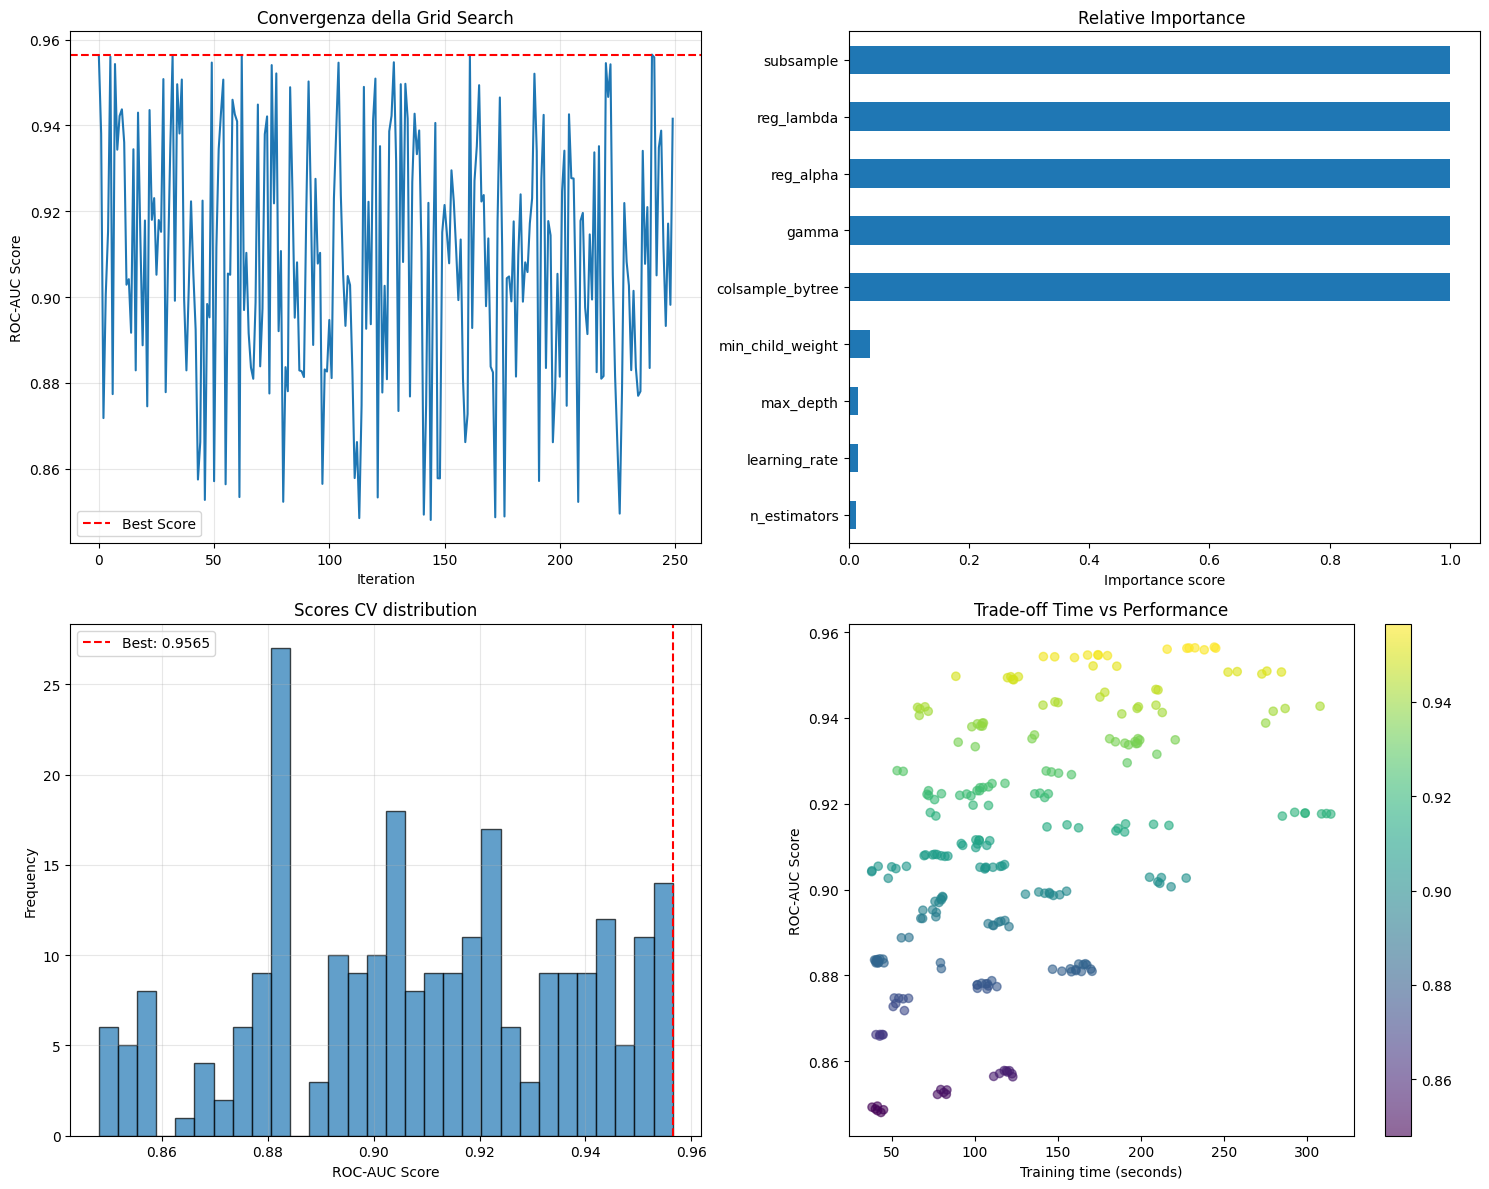


=== Finalizing model ===
Splitting training data for final model training...

Metrics on test set:
Accuracy: 0.9187
Precision: 0.9207
Recall: 0.9691
F1 Score: 0.9443
Roc Auc: 0.9570
Average Precision: 0.9779

=== Saving finalized model and scaler ===
Model saved in: ./models/geoxgboost_run_200825_1442_F\geok_xgboost_dev_model_200825_1442_F.joblib
Scaler saved in: ./models/geoxgboost_run_200825_1442_F\geok_xgboost_dev_model_200825_1442_F_scaler.joblib
Saving voters...
Error saving: [Errno 2] No such file or directory: 'models/voters/geok_xgboost_voter.joblib'

=== Data Viz ===


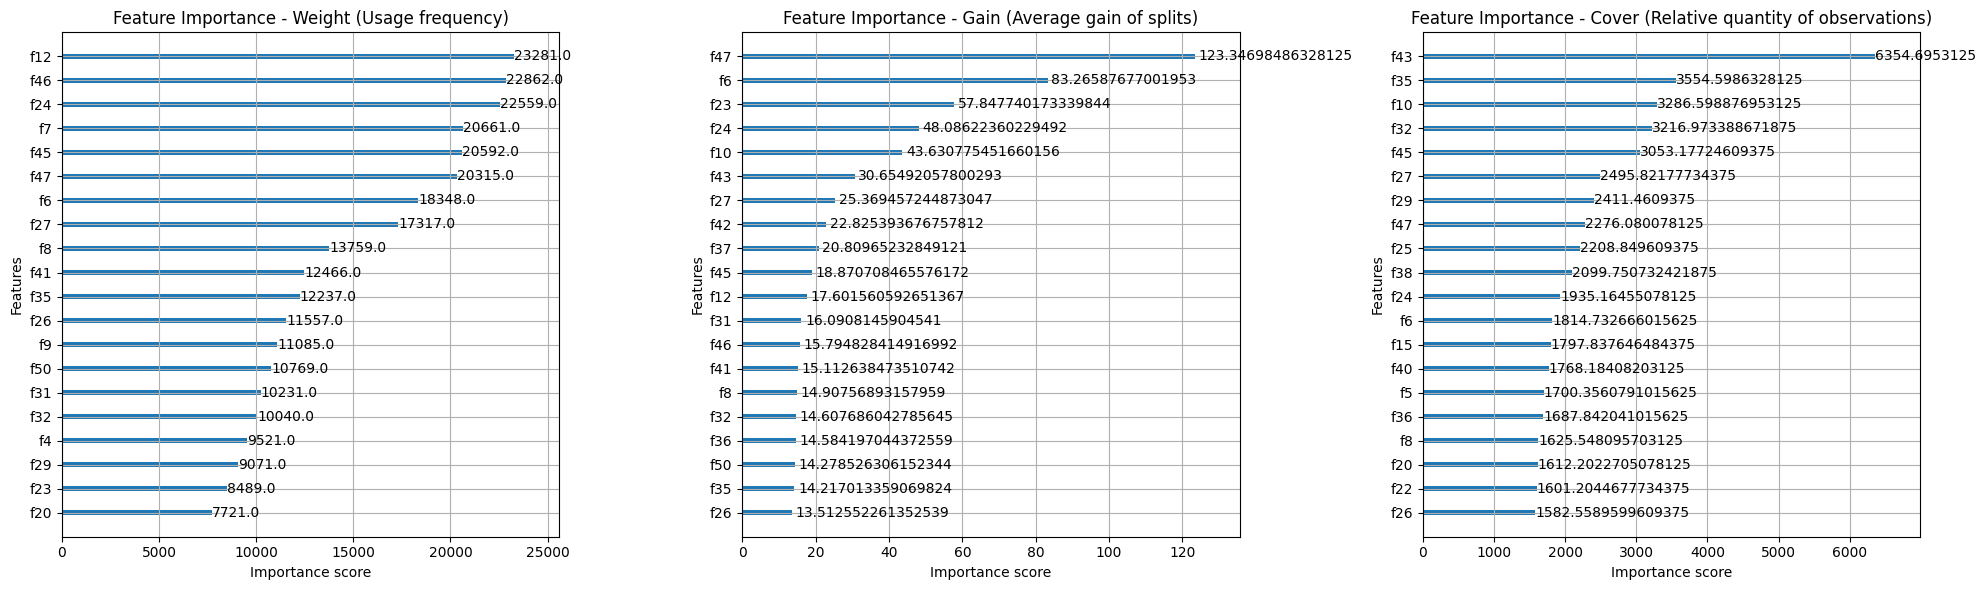

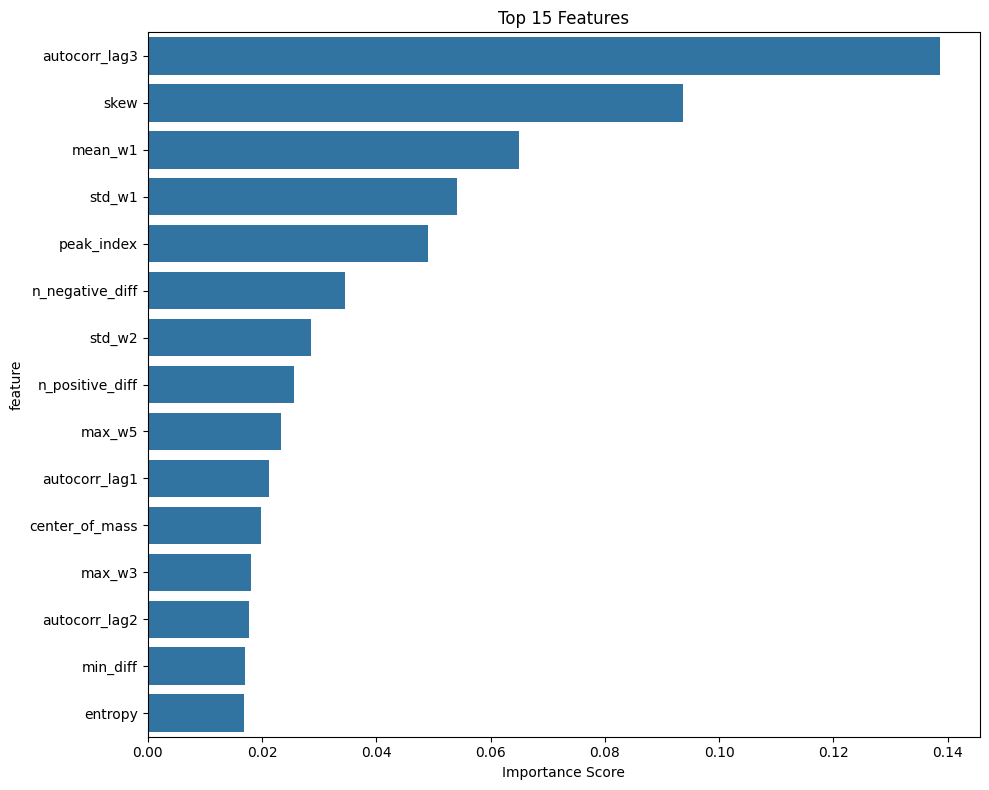

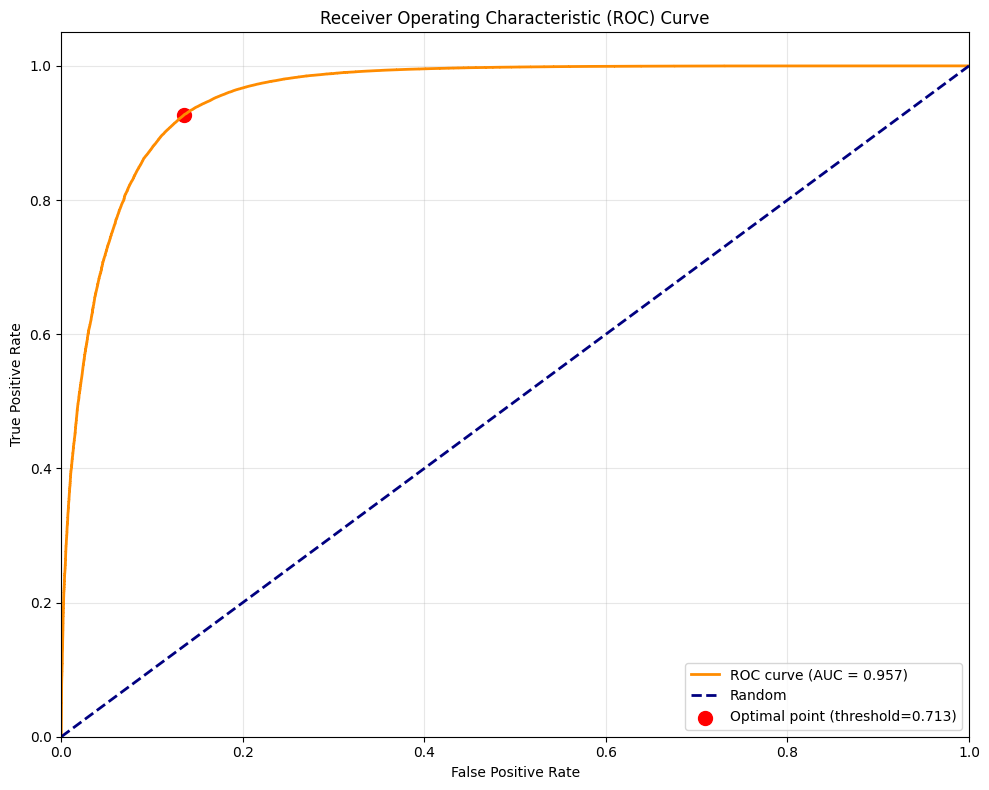

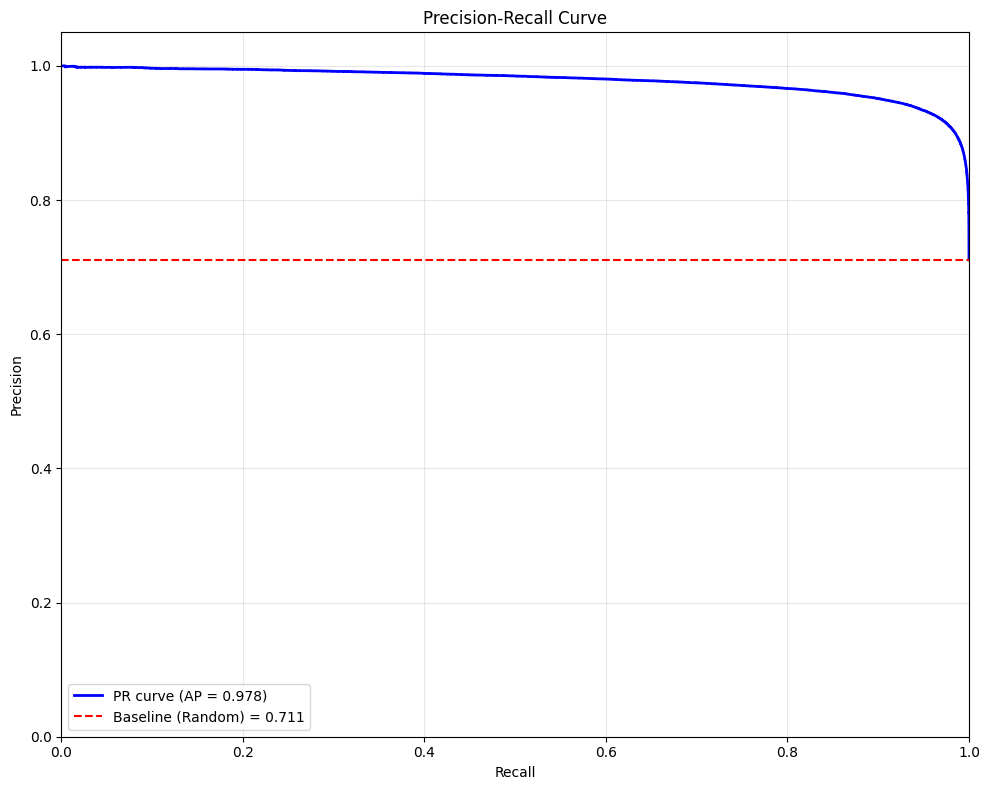

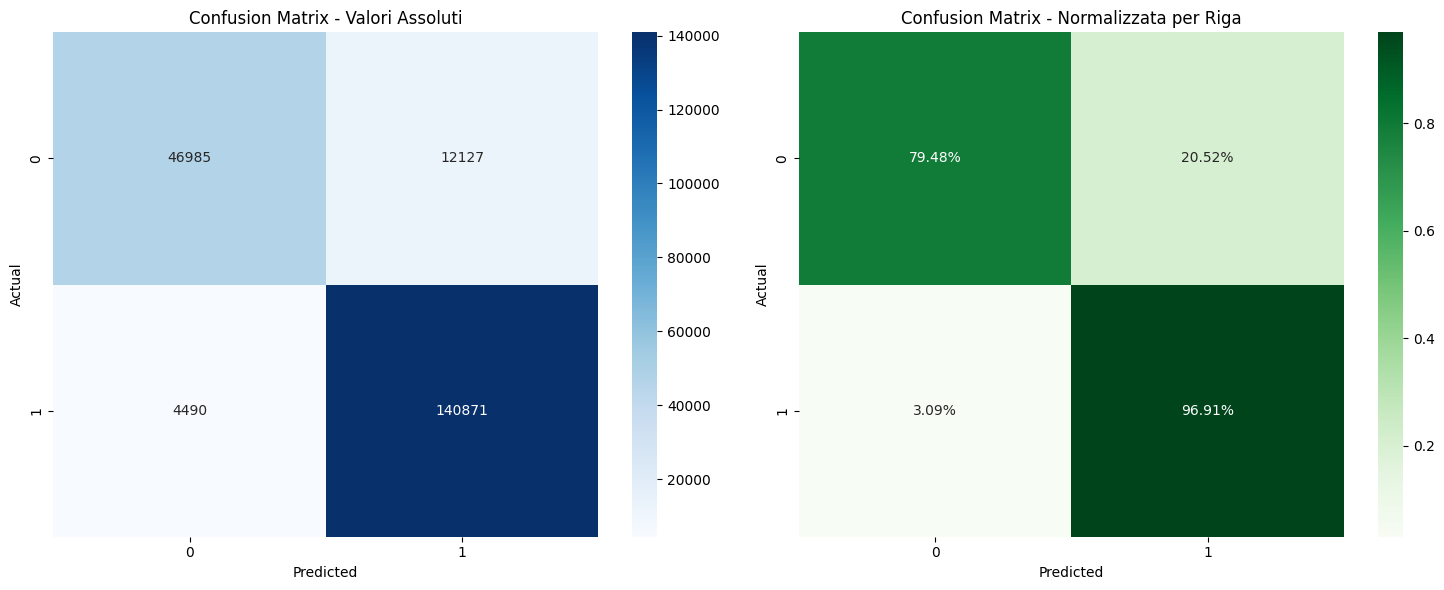

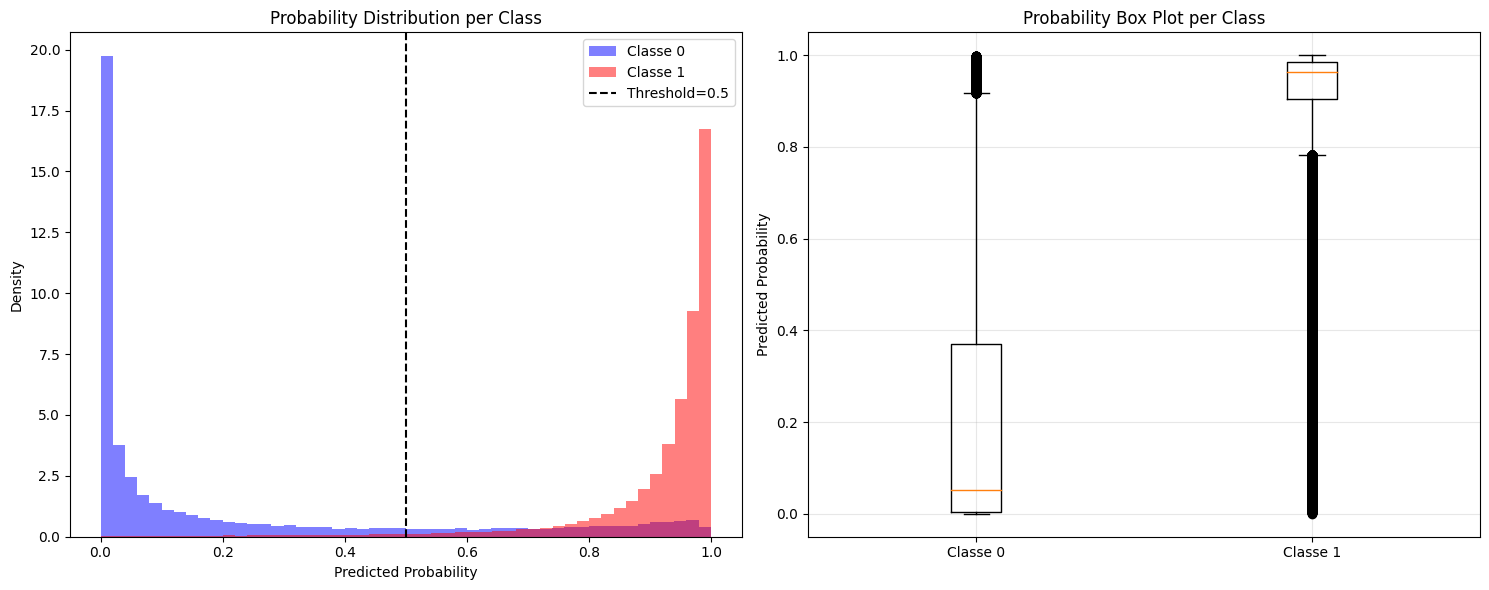

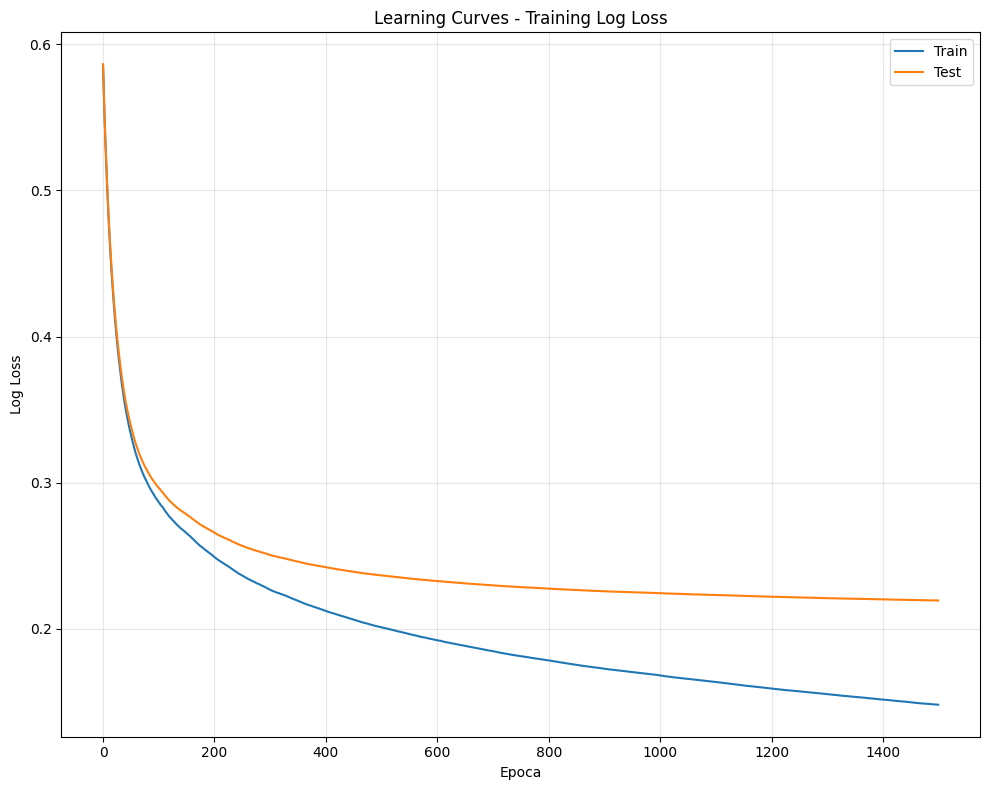

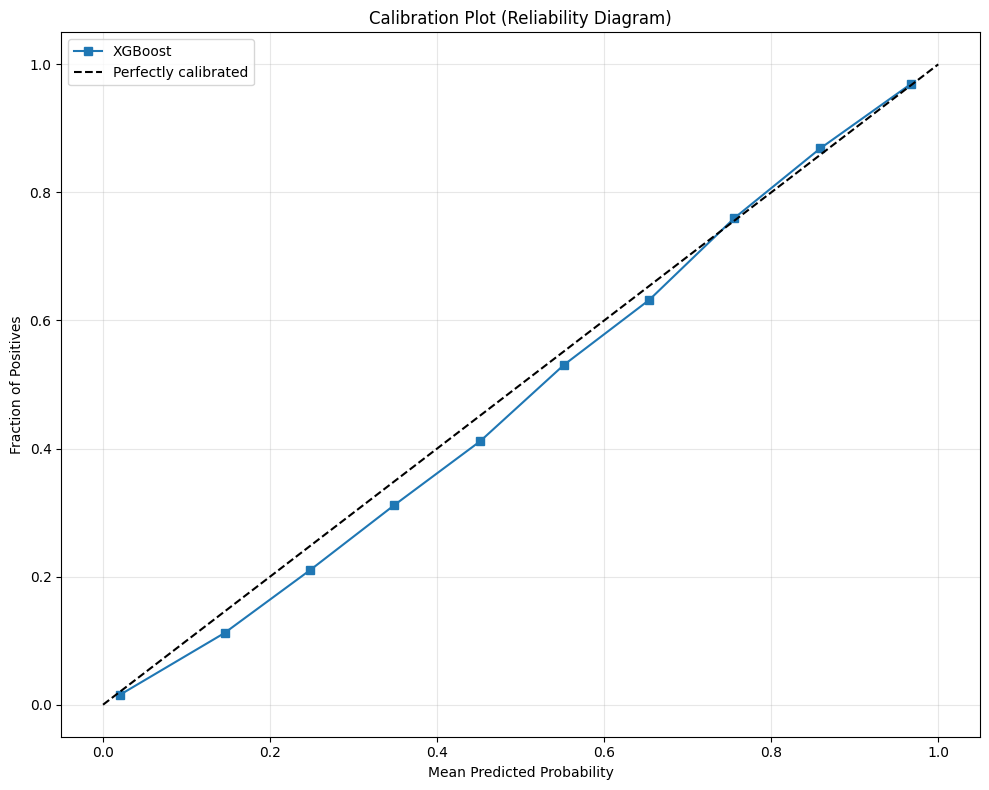

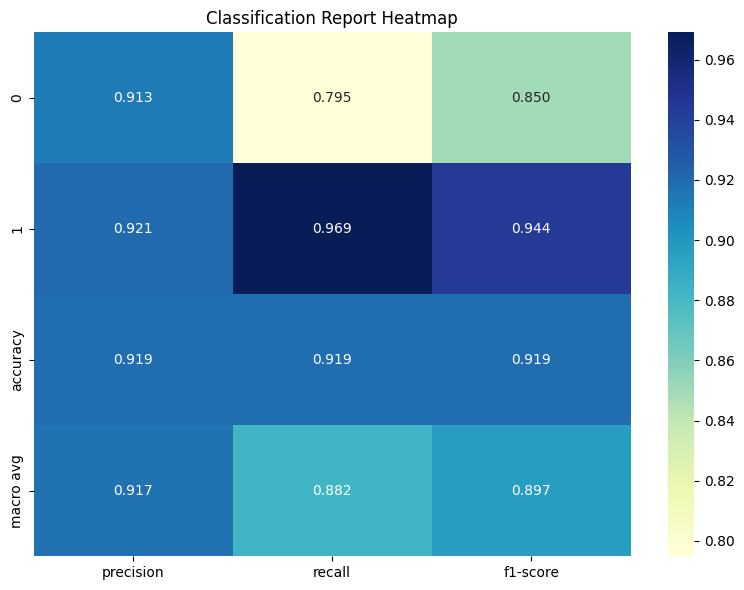

Plots saved on MLflow

=== PIPELINE COMPLETED ===
MLflow Run: 5280f1e3f4694569bbbe11518b62b1be
Modello saved in: None
Scaler saved in: None
🏃 View run melodic-colt-655 at: http://localhost:8080/#/experiments/588126380771053121/runs/5280f1e3f4694569bbbe11518b62b1be
🧪 View experiment at: http://localhost:8080/#/experiments/588126380771053121


In [18]:
date = datetime.now().strftime("%d%m%y_%H%M")

# Starting pipeline
pipeline = XGBoostPipeline(
    features_df=X_subset,
    labels_df=y_subset,
    experiment_name=f"geok_xgboost_experiment_{date}_F",
    model_save_dir=f"./models/geoxgboost_run_{date}_F", #TODO
    save_voter=True,
)

# Run pipeline
model, best_params, run_id = pipeline.run_complete_pipeline(
    model_name=f"geok_xgboost_dev_model_{date}_F"
)

### DEEPTEST

In [25]:
from collections import Counter
from joblib import load
import numpy as np

In [26]:
xg_boost_model_path = "./models/geoxgboost_run_200825_1442_F\geok_xgboost_dev_model_200825_1442_F.joblib"
xg_boost_scaler_path = "./models/geoxgboost_run_200825_1442_F\geok_xgboost_dev_model_200825_1442_F_scaler.joblib"
xg_boost_scaler = load(xg_boost_scaler_path)

In [27]:
models = {
    'xgboost': load(xg_boost_model_path)}

xg_boost_model_final = True

In [33]:
fit_data_with_features_df

,mean,std,min,max,median,range,skew,kurtosis,entropy,gini,...,n_positive_diff,n_negative_diff,n_zero_diff,autocorr_lag1,autocorr_lag2,autocorr_lag3,fft_peak_freq,fft_max,fft_median,fft_mean
0,2.067257,1.556976,1.000000e-10,5.397673,1.914673,5.397673,0.486536,-0.512070,2.651709,0.421555,...,10.0,9.0,0.0,0.235397,0.527550,0.021427,0.0,41.345137,4.968898,9.691896
1,0.839392,0.533016,1.000000e-10,1.738595,0.912359,1.738595,-0.253523,-0.945614,2.708911,0.359373,...,8.0,11.0,0.0,-0.033208,0.221307,0.182736,0.0,16.787842,2.502832,3.759962
2,1.926672,1.369952,1.000000e-10,4.614893,1.711636,4.614893,0.255423,-0.800592,2.673219,0.400862,...,8.0,11.0,0.0,0.232553,0.473585,0.089278,0.0,38.533433,5.815850,8.855536
3,1.417735,0.894406,1.000000e-10,2.867296,1.418138,2.867296,-0.229625,-0.881034,2.712801,0.354780,...,7.0,12.0,0.0,0.033329,0.285966,0.205698,0.0,28.354698,3.753740,6.290839
4,2.081495,1.555314,1.000000e-10,5.358918,1.863334,5.358918,0.456955,-0.558682,2.654891,0.418659,...,10.0,9.0,0.0,0.237994,0.529540,0.028895,0.0,41.629903,5.207048,9.691243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555899,1.404521,0.977370,1.000000e-10,3.078938,1.445337,3.078938,0.036541,-1.057277,2.674142,0.396291,...,10.0,9.0,0.0,-0.185670,0.118163,-0.141692,0.0,28.090420,4.196925,6.736693
2555900,0.993499,0.678393,1.000000e-10,2.057988,0.873861,2.057988,-0.058822,-1.178641,2.681402,0.388904,...,9.0,10.0,0.0,-0.209287,0.258471,-0.237185,0.0,19.869980,2.788763,4.697845
2555901,0.880584,0.566527,1.000000e-10,1.651357,0.851738,1.651357,-0.301279,-1.175654,2.701610,0.364655,...,9.0,10.0,0.0,-0.108197,0.179374,-0.076710,0.0,17.611674,2.545031,4.068160
2555902,1.013831,0.738867,1.000000e-10,2.316802,0.820300,2.316802,0.166666,-1.125822,2.655819,0.414492,...,9.0,10.0,0.0,-0.233031,0.256685,-0.277815,0.0,20.276628,3.146223,4.951593


In [38]:
labels_clean_df.rename(columns={'0': 'label'}, inplace=True)

In [ ]:
# Example: select rows by index from fit_data_with_features_df
# Replace [0, 1, 2] with your desired row indices
selected_rows = fit_data_with_features_df.iloc[[0, 1, 2]]
selected_rows

In [43]:
# Create subsets of the data with balanced classes
num_subsets = 5
subset_size = 20000

subsets_X_filtered = []
subsets_y_filtered = []

# Trova gli indici delle due classi
idx_0 = np.where(labels_clean_df == 0)[0]
idx_1 = np.where(labels_clean_df== 1)[0]
min_class_size = min(len(idx_0), len(idx_1), subset_size // 2)

for i in range(num_subsets):
    idx_0_sample = np.random.choice(idx_0, size=min_class_size, replace=False)
    idx_1_sample = np.random.choice(idx_1, size=min_class_size, replace=False)
    idx_balanced = np.concatenate([idx_0_sample, idx_1_sample])
    np.random.shuffle(idx_balanced)
    subsets_X_filtered.append(fit_data_with_features_df.iloc[idx_balanced])
    subsets_y_filtered.append(labels_clean_df.iloc[idx_balanced])

# Check the size of each subset and the distribution of classes
for i, (X, y) in enumerate(zip(subsets_X_filtered, subsets_y_filtered)):
    assert len(X) == subset_size, f"Subset {i+1} size mismatch: {len(X)} != {subset_size}"
    assert len(y) == subset_size, f"Subset {i+1} labels size mismatch: {len(y)} != {subset_size}"
    print(f"Subset {i+1}: {Counter(y)}")

# Check if all elements in subsets_X_unfiltered are different
all_unique = True
for i in range(num_subsets):
    for j in range(i + 1, num_subsets):
        if np.array_equal(subsets_X_filtered[i], subsets_X_filtered[j]):
            print(f"Subset {i+1} and Subset {j+1} are identical!")
            all_unique = False
if all_unique:
    print("All subsets in subsets_X_filtered are different.")

Subset 1: Counter({'label': 1})
Subset 2: Counter({'label': 1})
Subset 3: Counter({'label': 1})
Subset 4: Counter({'label': 1})
Subset 5: Counter({'label': 1})
All subsets in subsets_X_filtered are different.


In [47]:
# Preprocessing for xg_boost_model_final (dict with scaler and label_encoder)

def preprocess_for_xgboost(X):
    return xg_boost_scaler.transform(X)

def predict_with_xgboost(X):
    X_proc = preprocess_for_xgboost(X)
    model = load(xg_boost_model_path)
    return model.predict(X_proc)

# Preprocessing for sklearn models 
def preprocess_for_sklearn(X):
    # Assume features are already in correct format
    return X

def predict_with_sklearn(model, X):
    X_proc = preprocess_for_sklearn(X)
    return model.predict(X_proc)


=== xgboost ===
Subset 1: Accuracy = 0.8918
Confusion Matrix:
[[8102 1898]
 [ 267 9733]]
Subset 2: Accuracy = 0.8919
Confusion Matrix:
[[8098 1902]
 [ 260 9740]]
Subset 3: Accuracy = 0.8904
Confusion Matrix:
[[8083 1917]
 [ 274 9726]]
Subset 4: Accuracy = 0.8948
Confusion Matrix:
[[8169 1831]
 [ 273 9727]]
Subset 5: Accuracy = 0.8913
Confusion Matrix:
[[8102 1898]
 [ 275 9725]]
Mean Accuracy: 0.8921
Std Accuracy: 0.0015
Mean Confusion Matrix:
[[8110 1889]
 [ 269 9730]]

Media accuratezze: 0.8921 ± 0.0015
Confusion Matrix media:
[[8110 1889]
 [ 269 9730]]


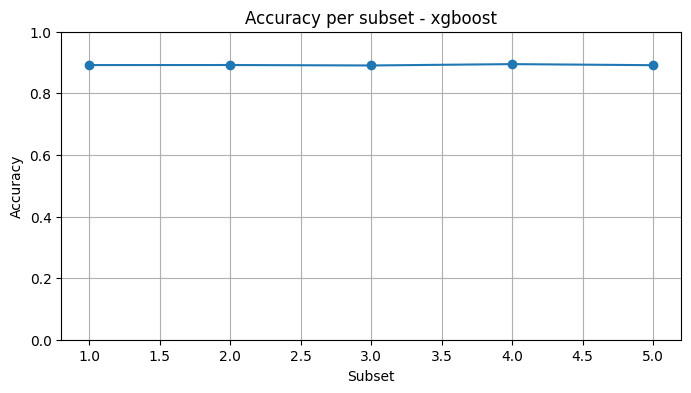

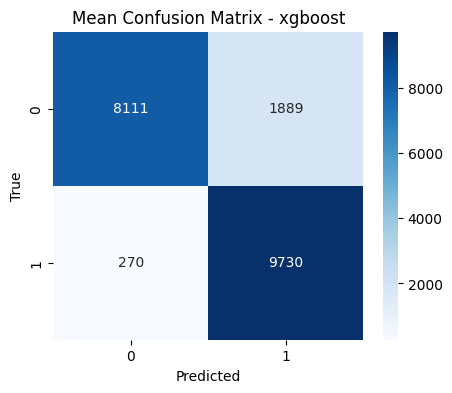

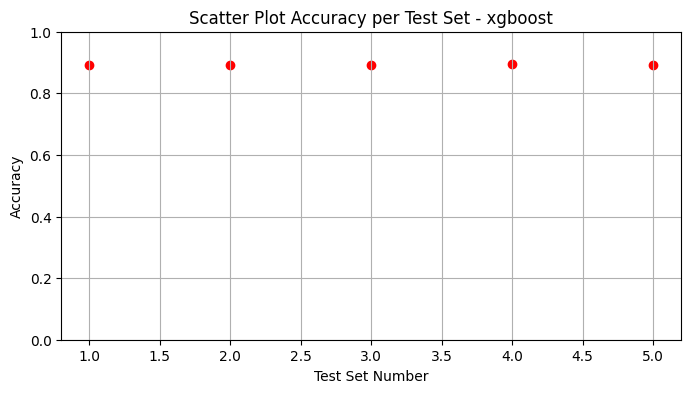

In [48]:

# Build models dict with wrappers for preprocessing

models = {}

if xg_boost_model_final is not None:
    models["xgboost"] = type(
        "XGBWrapper", (), {"predict": staticmethod(predict_with_xgboost)}
    )()

#if best_binary_classification_model is not None:
    #models["Best Binary Classification Model"] = type(
    #    "PyCaretWrapper", (), {"predict": staticmethod(lambda X: predict_with_pycaret(best_binary_classification_model, X))}
    #)()

#if best_random_forest_model is not None:
    #models["Best Random Forest Model"] = type(
    #    "RFWrapper", (), {"predict": staticmethod(lambda X: predict_with_sklearn(best_random_forest_model, X))}
    #)()

#if best_binary_classification_ensembled_model is not None:
    #models["Best Binary Classification Ensembled Model"] = type(
    #    "PyCaretEnsembleWrapper", (), {"predict": staticmethod(lambda X: predict_with_pycaret(best_binary_classification_ensembled_model, X))}
    #)()

#if catboost_model_final is not None:
#    models["catboost"] = type(
#        "CatBoostWrapper", (), {"predict": staticmethod(predict_with_catboost)}
#    )()

#if voting_classifier is not None:
#    models["Voting Classifier"] = type(
#        "VotingClassifierWrapper", (), {"predict": staticmethod(lambda X: voting_classifier.predict(X))}
#    )()

for model_name, model in models.items():
    print(f"\n=== {model_name} ===")
    accs = []
    cms = []
    for i in range(num_subsets):
        X = subsets_X_filtered[i]
        y = subsets_y_filtered[i]

        # Searching for the optimal threshold if the model supports it
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X)[:, 1]
            fpr, tpr, thresholds = roc_curve(y, y_proba)
            # Soglia ottimale: massimizza tpr - fpr (Youden's J statistic)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
            print(f"SOGLIA OTTIMALE DI CLASSIFICAZIONE: {optimal_threshold:.4f}")
            y_pred = (y_proba >= optimal_threshold).astype(int)
        else:
            y_pred = model.predict(X)

        acc = accuracy_score(y, y_pred)
        cm = confusion_matrix(y, y_pred)
        print(f"Subset {i+1}: Accuracy = {acc:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        accs.append(acc)
        cms.append(cm)
    print(f"Mean Accuracy: {np.mean(accs):.4f}")
    print(f"Std Accuracy: {np.std(accs):.4f}")
    print(f"Mean Confusion Matrix:\n{np.mean(np.array(cms), axis=0).astype(int)}")

    # AVG accuracy and confusion matrix across all subsets
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    mean_cm = np.mean(np.array(cms), axis=0)
    print(f"\nMedia accuratezze: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"Confusion Matrix media:\n{mean_cm.astype(int)}")
    import matplotlib.pyplot as plt

    # Plot accuracy per subset
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_subsets + 1), accs, marker='o')
    plt.title(f'Accuracy per subset - {model_name}')
    plt.xlabel('Subset')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

    # Plot mean confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(mean_cm, annot=True, fmt='.0f', cmap='Blues')
    plt.title(f'Mean Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Calcola il classification report medio su tutti i subset
    reports = []
    for i in range(num_subsets):
        y_true = subsets_y_filtered[i]
        y_pred = model.predict(subsets_X_filtered[i])
        report = classification_report(y_true, y_pred, output_dict=True)
        reports.append(report)

    plt.figure(figsize=(8, 4))
    plt.scatter(range(1, num_subsets + 1), accs, color='red')
    plt.title(f'Scatter Plot Accuracy per Test Set - {model_name}')
    plt.xlabel('Test Set Number')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()